# **DDoS Model Training (Neural Network)**
---

## **Imports and Configuration**
---

In [1]:
import json
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf
import tensorflow.keras.layers as tfl
import warnings

from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# Data, encoders and normalizer paths
dataset_name = '75-20-05-udplag.syn'

input_path = os.path.join('data/clean', dataset_name)
encoders_path = os.path.join(input_path, 'encoders')
stats_path = os.path.join(input_path, 'stats')
data_path = os.path.join(input_path, 'split-sets-balanced-smote')

# Model paths settings
model_type = 'neural-network' # <- Change for other models
models_path = os.path.join('models', model_type)

## **Load Encoders and Normalizing Stats**
---

In [4]:
# Load label encoder
with open(os.path.join(encoders_path, 'label-encoder.pkl'), 'rb') as file:
    label_encoder = pickle.load(file)

# Load one-hot encoder
with open(os.path.join(encoders_path, 'onehot-encoder.pkl'), 'rb') as file:
    onehot_encoder = pickle.load(file)
    
# Load standard scaler
with open(os.path.join(stats_path, 'standard-scaler.pkl'), 'rb') as file:
    standard_scaler = pickle.load(file)

# Load L2 normalizer
with open(os.path.join(stats_path, 'l2-normalizer.pkl'), 'rb') as file:
    l2_normalizer = pickle.load(file)

# Load quantile transformer
with open(os.path.join(stats_path, 'quantile-transformer.pkl'), 'rb') as file:
    quantile_transformer = pickle.load(file)

## **Load Data**
---

In [5]:
# Load Data
X_train = pd.read_csv(os.path.join(data_path, 'X_train.csv'))
y_train = pd.read_csv(os.path.join(data_path, 'y_train.csv'))
X_val = pd.read_csv(os.path.join(data_path, 'X_val.csv'))
y_val = pd.read_csv(os.path.join(data_path, 'y_val.csv'))
X_test = pd.read_csv(os.path.join(data_path, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(data_path, 'y_test.csv'))

In [6]:
unique_labels = y_train['Label'].unique()
print(f'Unique labels = {unique_labels}')

Unique labels = ['Syn/UDPLag' 'DNS/LDAP' 'NetBIOS/Portmap' 'MSSQL' 'SNMP' 'SSDP/UDP' 'NTP'
 'TFTP' 'BENIGN']


## **Normalize and Transform (X, y) Data**
---

In [7]:
# Standard normalization of X
X_train = standard_scaler.transform(X_train)
X_val = standard_scaler.transform(X_val)
X_test = standard_scaler.transform(X_test)

In [7]:
# L2 normalization and quantile transformation of X
X_train = l2_normalizer.transform(X_train)
X_val = l2_normalizer.transform(X_val)
X_test = l2_normalizer.transform(X_test)

X_train = quantile_transformer.transform(X_train)
X_val = quantile_transformer.transform(X_val)
X_test = quantile_transformer.transform(X_test)

In [8]:
# One-hot encoding of y
y_train_onehot = onehot_encoder.transform(y_train)
y_val_onehot = onehot_encoder.transform(y_val)
y_test_onehot = onehot_encoder.transform(y_test)

# Label encoding of y
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [9]:
print(f'       X_train.shape = {X_train.shape}')
print(f'       y_train.shape = {y_train.shape}')
print(f'y_train_onehot.shape = {y_train_onehot.shape}\n')

print(f'         X_val.shape = {X_val.shape}')
print(f'         y_val.shape = {y_val.shape}')
print(f'  y_val_onehot.shape = {y_val_onehot.shape}\n')

print(f'        X_test.shape = {X_test.shape}')
print(f'        y_test.shape = {y_test.shape}')
print(f' y_test_onehot.shape = {y_test_onehot.shape}')

       X_train.shape = (11916819, 78)
       y_train.shape = (11916819,)
y_train_onehot.shape = (11916819, 9)

         X_val.shape = (1770568, 78)
         y_val.shape = (1770568,)
  y_val_onehot.shape = (1770568, 9)

        X_test.shape = (442643, 78)
        y_test.shape = (442643,)
 y_test_onehot.shape = (442643, 9)


## **Model Settings**
---

In [10]:
# Model hyperparameter definition
input_dim = X_train.shape[1]
n_classes = y_train_onehot.shape[1]
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
dropout_rate = 0.3
batch_size = 256
epochs = 20

In [11]:
# Model architecture
model = tf.keras.Sequential([
    tfl.Dense(128, input_shape=(input_dim,)),
    tfl.LeakyReLU(alpha=0.01),
    tfl.Dense(256),
    tfl.LeakyReLU(alpha=0.01),
    tfl.Dense(512),
    tfl.LeakyReLU(alpha=0.01),
    tfl.Dropout(dropout_rate),
    tfl.Dense(n_classes, activation='softmax')
])

# Show architecture summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          10,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 179,337 (700.54 KB)

 Trainable params: 179,337 (700.54 KB)

 Non-trainable params: 0 (0.00 B)

## **Model Training and Persistence**
---

In [12]:
# Compile the model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model training
history = model.fit(
    X_train,
    y_train_onehot.todense(),
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val_onehot.todense())
)

Epoch 1/20
46551/46551 ━━━━━━━━━━━━━━━━━━━━ 264s 6ms/step - accuracy: 0.8640 - loss: 0.4181 - val_accuracy: 0.8903 - val_loss: 0.3432
Epoch 2/20
46551/46551 ━━━━━━━━━━━━━━━━━━━━ 261s 6ms/step - accuracy: 0.8896 - loss: 0.3207 - val_accuracy: 0.8904 - val_loss: 0.3310
Epoch 3/20
46551/46551 ━━━━━━━━━━━━━━━━━━━━ 261s 6ms/step - accuracy: 0.8917 - loss: 0.3113 - val_accuracy: 0.8828 - val_loss: 0.3495
Epoch 4/20
46551/46551 ━━━━━━━━━━━━━━━━━━━━ 263s 6ms/step - accuracy: 0.8931 - loss: 0.3080 - val_accuracy: 0.8948 - val_loss: 0.3219
Epoch 5/20
46551/46551 ━━━━━━━━━━━━━━━━━━━━ 263s 6ms/step - accuracy: 0.8940 - loss: 0.3059 - val_accuracy: 0.8937 - val_loss: 0.3237
Epoch 6/20
46551/46551 ━━━━━━━━━━━━━━━━━━━━ 264s 6ms/step - accuracy: 0.8945 - loss: 0.3040 - val_accuracy: 0.8918 - val_loss: 0.3283
Epoch 7/20
46551/46551 ━━━━━━━━━━━━━━━━━━━━ 265s 6ms/step - accuracy: 0.8948 - loss: 0.3026 - val_accuracy: 0.8948 - val_loss: 0.3187
Epoch 8/20
46551/46551 ━━━━━━━━━━━━━━━━━━━━ 265s 6ms/step - ac

In [13]:
# Define normalize method name
normalize_name = 'standard-v4'

# Save model architecture
with open(os.path.join(models_path, f'model-nn-{normalize_name}.architecture.json'), 'w') as file:
    file.write(model.to_json())

# Save model weights
model.save_weights(os.path.join(models_path, f'model-nn-{normalize_name}.weights.h5'))

# Save model history
with open(os.path.join(models_path, f'model-nn-{normalize_name}.history.json'), 'w') as file:
    json.dump(history.history, file)

## **Model Evaluation**
---

In [14]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred, target_names=list(label_encoder.classes_)))

13833/13833 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
Accuracy = 0.8966209789830631

                 precision    recall  f1-score   support

         BENIGN       0.94      1.00      0.97      2827
       DNS/LDAP       0.82      0.76      0.79     40987
          MSSQL       0.91      0.93      0.92     48599
            NTP       0.98      1.00      0.99     48900
NetBIOS/Portmap       0.83      0.96      0.89     58680
           SNMP       0.74      0.66      0.70     49756
       SSDP/UDP       0.95      0.94      0.95     56214
     Syn/UDPLag       0.93      0.97      0.95     87766
           TFTP       1.00      0.86      0.93     48914

       accuracy                           0.90    442643
      macro avg       0.90      0.90      0.90    442643
   weighted avg       0.90      0.90      0.90    442643



## **Load Model**

In [16]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import warnings

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from tensorflow.keras.models import model_from_json

warnings.filterwarnings('ignore')

In [2]:
encoders_path = 'data/clean/encoders'
stats_path = 'data/clean/stats'
data_path = 'data/clean/split-sets-balanced-smote'

model_type = 'neural-network'
models_path = os.path.join('models', model_type)

In [3]:
# Load label encoder
with open(os.path.join(encoders_path, 'label-encoder.pkl'), 'rb') as file:
    label_encoder = pickle.load(file)
    
# Load standard scaler
with open(os.path.join(stats_path, 'standard-scaler.pkl'), 'rb') as file:
    standard_scaler = pickle.load(file)

In [4]:
X_test = pd.read_csv(os.path.join(data_path, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(data_path, 'y_test.csv'))

X_test = standard_scaler.transform(X_test)
y_test = label_encoder.transform(y_test)

In [5]:
# Define normalize method name
normalize_name = 'standard-v3'

# Load model architecture
with open(os.path.join(models_path, f'model-nn-{normalize_name}.architecture.json'), 'r') as file:
    model = model_from_json(file.read())

# Load weights
model.load_weights(os.path.join(models_path, f'model-nn-{normalize_name}.weights.h5'))

# Check model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          10,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 539,552 (2.06 MB)

 Trainable params: 179,850 (702.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 359,702 (1.37 MB)

In [6]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

13884/13884 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step


In [7]:
print(f'Accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred, target_names=list(label_encoder.classes_)))

Accuracy = 0.853094767549171

                 precision    recall  f1-score   support

         BENIGN       0.94      1.00      0.97      2858
       DNS/LDAP       0.81      0.76      0.79     41583
          MSSQL       0.90      0.93      0.91     48299
            NTP       0.98      0.99      0.99     48911
NetBIOS/Portmap       0.83      0.95      0.89     58850
           SNMP       0.73      0.66      0.69     49591
       SSDP/UDP       0.95      0.94      0.94     56400
            Syn       1.00      0.74      0.85     72230
           TFTP       1.00      0.86      0.92     48819
         UDPLag       0.35      0.85      0.50     16725

       accuracy                           0.85    444266
      macro avg       0.85      0.87      0.85    444266
   weighted avg       0.89      0.85      0.86    444266



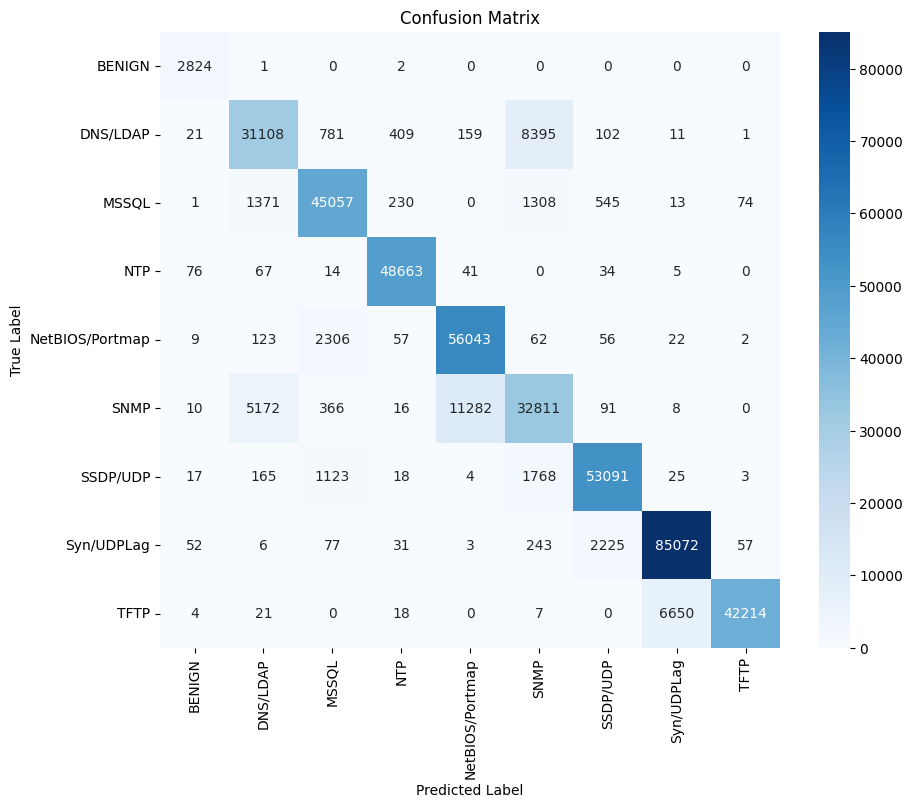

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_encoder.classes_), yticklabels=list(label_encoder.classes_))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

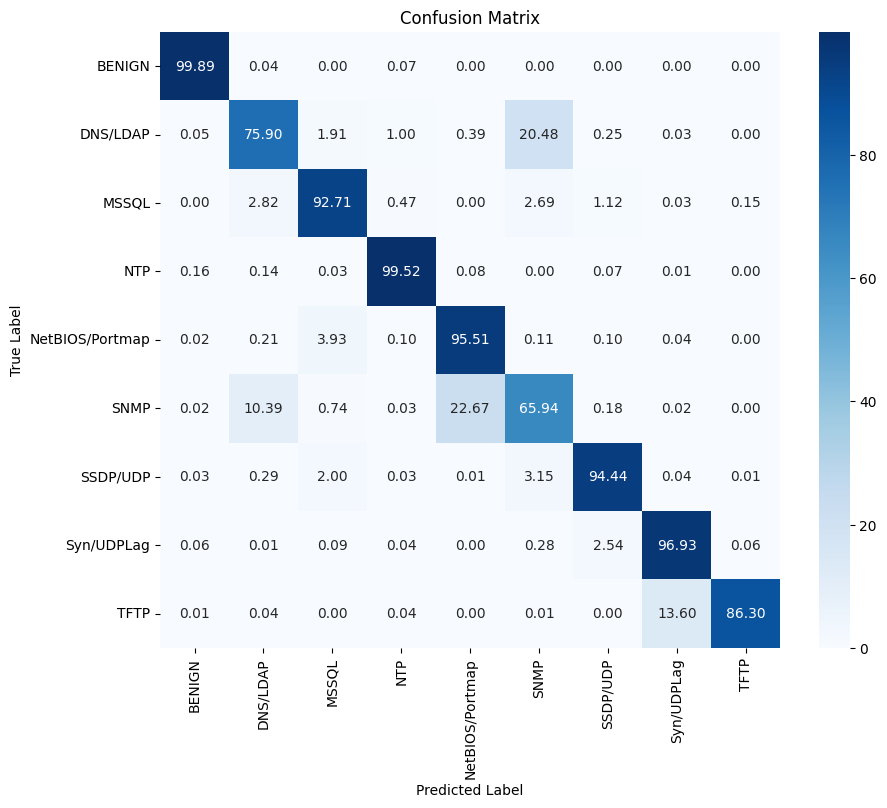

In [18]:
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(label_encoder.classes_), yticklabels=list(label_encoder.classes_))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()